In [17]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.messages import StructuredMessage
from autogen_agentchat.ui import Console
from autogen_core.models import ChatCompletionClient

In [ ]:
config = {
    "provider": "OpenAIChatCompletionClient",
    "config": {
        "model": "qwen2-vl-2b-instruct",
        "base_url": "http://127.0.0.1:1234/v1",
        "api_key": "lm-studio",
        "model_info": {
            "name": "qwen2-vl-2b-instruct",
            "family": "openai",
            "supports_tool_calling": True,
            "supports_json_mode": False,
            "structured_output": True,
            "json_output": True,
            "function_calling": True,
            "vision": True,
        }
    }
}

model_client = ChatCompletionClient.load_component(config)

## Assistant Agent

In [19]:
# Define a tool that searches the web for information.
# For simplicity, we will use a mock function here that returns a static string.
async def web_search(query: str) -> str:
    """Find information on the web"""
    return "AutoGen is a programming framework for building multi-agent applications."

agent = AssistantAgent(
    name="assistant",
    model_client=model_client,
    tools=[web_search],
    system_message="Use tools to solve tasks.",
)

## Getting Result

In [20]:
# Use asyncio.run(agent.run(...)) when running in a script.
result = await agent.run(task="Find information on AutoGen")
print(result.messages)

[TextMessage(source='user', models_usage=None, metadata={}, content='Find information on AutoGen', type='TextMessage'), ToolCallRequestEvent(source='assistant', models_usage=RequestUsage(prompt_tokens=370, completion_tokens=29), metadata={}, content=[FunctionCall(id='351606468', arguments='{"query":"AutoGen"}', name='web_search')], type='ToolCallRequestEvent'), ToolCallExecutionEvent(source='assistant', models_usage=None, metadata={}, content=[FunctionExecutionResult(content='AutoGen is a programming framework for building multi-agent applications.', name='web_search', call_id='351606468', is_error=False)], type='ToolCallExecutionEvent'), ToolCallSummaryMessage(source='assistant', models_usage=None, metadata={}, content='AutoGen is a programming framework for building multi-agent applications.', type='ToolCallSummaryMessage')]


## Multi-Modal Input


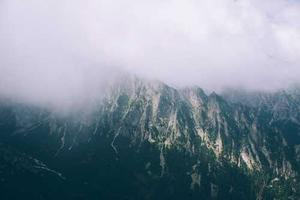

In [21]:
from io import BytesIO

import PIL
import requests
from autogen_agentchat.messages import MultiModalMessage
from autogen_core import Image

# Create a multi-modal message with random image and text.
pil_image = PIL.Image.open(
    BytesIO(requests.get("https://picsum.photos/300/200").content))
img = Image(pil_image)
multi_modal_message = MultiModalMessage(
    content=["Can you describe the content of this image?", img], source="user")
img

In [22]:
# Use asyncio.run(...) when running in a script.
result = await agent.run(task=multi_modal_message)
print(result.messages[-1].content)  # type: ignore

The image shows a mountain range with clouds and mist covering parts of it. The mountains are covered in greenery, and the sky appears to be overcast, giving the scene a somewhat mysterious or serene atmosphere.


## Streaming Messages

In [23]:
async def assistant_run_stream() -> None:
    # Option 1: read each message from the stream (as shown in the previous example).
    # async for message in agent.run_stream(task="Find information on AutoGen"):
    #     print(message)

    # Option 2: use Console to print all messages as they appear.
    await Console(
        agent.run_stream(task="Find information on AutoGen"),
        output_stats=True,  # Enable stats printing.
    )


# Use asyncio.run(assistant_run_stream()) when running in a script.
await assistant_run_stream()

---------- TextMessage (user) ----------
Find information on AutoGen
---------- ToolCallRequestEvent (assistant) ----------
[FunctionCall(id='370969803', arguments='{"query":"AutoGen"}', name='web_search')]
[Prompt tokens: 507, Completion tokens: 29]
---------- ToolCallExecutionEvent (assistant) ----------
[FunctionExecutionResult(content='AutoGen is a programming framework for building multi-agent applications.', name='web_search', call_id='370969803', is_error=False)]
---------- ToolCallSummaryMessage (assistant) ----------
AutoGen is a programming framework for building multi-agent applications.
---------- Summary ----------
Number of messages: 4
Finish reason: None
Total prompt tokens: 507
Total completion tokens: 29
Duration: 1.32 seconds


## Function Tool

In [24]:
from autogen_core.tools import FunctionTool


# Define a tool using a Python function.
async def web_search_func(query: str) -> str:
    """Find information on the web"""
    return "AutoGen is a programming framework for building multi-agent applications."


# This step is automatically performed inside the AssistantAgent if the tool is a Python function.
web_search_function_tool = FunctionTool(
    web_search_func, description="Find information on the web")
# The schema is provided to the model during AssistantAgent's on_messages call.
web_search_function_tool.schema

{'name': 'web_search_func',
 'description': 'Find information on the web',
 'parameters': {'type': 'object',
  'properties': {'query': {'description': 'query',
    'title': 'Query',
    'type': 'string'}},
  'required': ['query'],
  'additionalProperties': False},
 'strict': False}

## Structured Output

In [25]:
from typing import Literal

from pydantic import BaseModel


# The response format for the agent as a Pydantic base model.
class AgentResponse(BaseModel):
    thoughts: str
    response: Literal["happy", "sad", "neutral"]


agent = AssistantAgent(
    "assistant",
    model_client=model_client,
    system_message="Categorize the input as happy, sad, or neutral following the JSON format.",
    # Define the output content type of the agent.
    output_content_type=AgentResponse,
)

result = await Console(agent.run_stream(task="I am happy."))
assert isinstance(result.messages[-1], StructuredMessage)
assert isinstance(result.messages[-1].content, AgentResponse)
print("Thought: ", result.messages[-1].content.thoughts)
print("Response: ", result.messages[-1].content.response)
await model_client.close()

---------- TextMessage (user) ----------
I am happy.
---------- StructuredMessage[AgentResponse] (assistant) ----------
{"thoughts":"happy","response":"happy"}
Thought:  happy
Response:  happy


## Streaming Tokens

In [28]:
config = {
    "provider": "OpenAIChatCompletionClient",
    "config": {
        "model": "qwen2-vl-2b-instruct",
        "base_url": "http://127.0.0.1:1234/v1",
        "api_key": "lm-studio",
        "streaming":True,
        "model_info": {
            "name": "qwen2-vl-2b-instruct",
            "family": "openai",
            "supports_tool_calling": True,
            "supports_json_mode": False,
            "structured_output": True,
            "json_output": True,
            "function_calling": True,
            "vision": True,
        }
    }
}

model_client = ChatCompletionClient.load_component(config)

streaming_assistant = AssistantAgent(
    name="assistant",
    model_client=model_client,
    system_message="You are a helpful assistant.",
    model_client_stream=True,  # Enable streaming tokens.
)

# Use an async function and asyncio.run() in a script.
# type: ignore
async for message in streaming_assistant.run_stream(task="Name two cities in South America"):
    print(message)

source='user' models_usage=None metadata={} content='Name two cities in South America' type='TextMessage'
source='assistant' models_usage=None metadata={} content='The' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None metadata={} content=' two' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None metadata={} content=' cities' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None metadata={} content=' in' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None metadata={} content=' South' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None metadata={} content=' America' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None metadata={} content=' that' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None metadata={} content=' you' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None metadata={} content=' might' type

## Using Model Context

In [29]:
from autogen_core.model_context import BufferedChatCompletionContext

# Create an agent that uses only the last 5 messages in the context to generate responses.
agent = AssistantAgent(
    name="assistant",
    model_client=model_client,
    tools=[web_search],
    system_message="Use tools to solve tasks.",
    # Only use the last 5 messages in the context.
    model_context=BufferedChatCompletionContext(buffer_size=5),
)

In [30]:
# Use asyncio.run(...) when running in a script.
result = await agent.run(task=multi_modal_message)
print(result.messages[-1].content)  # type: ignore

Certainly! The image depicts a mountain range partially obscured by clouds. The peaks are visible through the gaps in the mist, showcasing a mix of green and rocky terrain. The overall scene conveys a sense of mystery and tranquility as the natural landscape is enveloped in a layer of fog or mist.
